#I- Introduction
Il existe plusieurs types de modèles qui pourraient être utilisés pour la classification de texte. Quelques exemples sont :


*   **1D- Conv Net** 

*   **Modèles basés sur RNN (LSTM, GRU)** 

* **Modèles basés sur des transformers (BERT, GPT2)** 

####nous avons testé les 3 types de modèles et les CNN et Bert ont montré des très bonne performance
####Dans ce projet nous allons essayer de combiner les deux pour avoir un model plus puissant qui tire parti des atouts de chaque type pour donner des meilleurs résultats.


### 1. Importing libraries and modules

In [1]:
!pip install tensorflow==2.3.0
!pip install tensorflow-gpu==2.3.0
!pip install keras==2.4.3
!pip cudatoolkit==11.0.221

     |████████████████████████████████| 320.4MB 45kB/s 
     |████████████████████████████████| 460kB 33.0MB/s 
     |████████████████████████████████| 2.9MB 15.4MB/s 
     |████████████████████████████████| 20.1MB 312kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow 

     |████████████████████████████████| 320.4MB 46kB/s 
ERROR: unknown command "cudatoolkit==11.0.221"


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from numpy import array
from tensorflow import keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
#from tensorflow.keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

In [4]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

###2. Loading Data

In [5]:
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [6]:
df1 = pd.read_csv(r'/gdrive/My Drive/bgl1.csv')
df2 = pd.read_csv(r'/gdrive/My Drive/t3.csv')
df3 = pd.read_csv(r'/gdrive/My Drive/open stack normal.csv')
df4 = pd.read_csv(r'/gdrive/My Drive/open stack abnormal.csv')

In [7]:
dfa= df1.loc[0:400000,:]
dfb= df2.loc[0:400000,:]

In [8]:
df3['label']=0
df4['label']=1

In [9]:
#concatinate
df=pd.concat([dfa,dfb,df3,df4])
# Shuffle the data
df = shuffle(df).reset_index(drop=True)
df.sample(10)

,Unnamed: 0,log,label
995050,98245,- 1117989454 2005.06.05 R35-M0-N0-C:J06-U01 20...,0
998473,95907,- 1117988395 2005.06.05 R34-M0-NA-C:J11-U11 20...,0
326317,154943,- 1131774831 2005.11.11 bn387 Nov 11 21:53:51 ...,0
403774,46169,nova-api.log.1.2017-05-16_13:53:08 2017-05-16 ...,0
929275,353491,KERNDTLB 1118555129 2005.06.11 R30-M0-N9-C:J16...,1
659272,68155,nova-compute.log.1.2017-05-17_12:02:35 2017-05...,0
772824,195945,- 1118290051 2005.06.08 R27-M0-NB-C:J02-U01 20...,0
898434,22429,nova-api.log.1.2017-05-16_13:53:08 2017-05-16 ...,0
812330,63133,- 1117979968 2005.06.05 R22-M0-N4-C:J09-U01 20...,0
302692,395909,KERNSTOR 1118709779 2005.06.13 R10-M1-N0-C:J10...,1


###3. Data Preprocessing

In [10]:
del df['Unnamed: 0']

In [11]:
df.shape

(1007822, 2)

In [12]:
def clean_data(log):
    log = re.sub("'", "", log)
    log = re.sub("-", "", log)
    log = re.sub("_", "", log)
    log = re.sub("(\\W)+", " ", log)
    log = log.lower()
    return log

In [13]:
df['log'] = df['log'].apply(clean_data)

* Split the dataset into train set 80% & test sets 20%

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['log'],df['label'], test_size=0.2,random_state=42)

### CNN Processing Part:

#### Preparing the Embedding Layer

nous utiliserons la classe Tokenizer du module keras.preprocessing.text pour créer un dictionnaire de word-to-index . Dans le dictionnaire, chaque mot est utilisé comme clé, tandis qu'un index unique correspondant est utilisé comme valeur pour la clé.

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Nous fixons la taille maximale à 100. Les listes de taille supérieure à 100 seront tronquées à 100. Pour les listes dont la longueur est inférieure à 100, nous ajouterons 0 à la fin de la liste jusqu'à ce qu'elle atteigne la longueur maximale.

In [16]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Nous utiliserons GloVe embeddings pour créer feature matrix, j'ai essayé d'importer Glove sur mon drive
* vous pouvez la trouver sur : https://drive.google.com/file/d/17PIgUPWrXOLFbUYqTAnl1cgWqnWHgX1B/view?usp=sharing

In [17]:
from numpy import array
from numpy import asarray
from numpy import zeros

glove_path=r'/gdrive/My Drive/glove.6B.100d.txt'
embeddings_dictionary = dict()
glove_file = open(glove_path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Enfin, nous allons créer une embedding matrix où chaque numéro de ligne correspondra à l'index du mot. La matrice aura 100 colonnes où chaque colonne contiendra les embeddings de mots GloVe.

In [18]:
embedding_matrix = zeros((vocab_size,100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

### Bert Processing Part:

### Build a BERT Layer

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling1D,Conv1D,GlobalMaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Input,Concatenate
import tensorflow_hub as hub
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2, Total size: 421.50MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.


### **PS: Pour Bert layer:**
* Inputs:

a) input token ids (tokenizer convertir les tokens à l'aide d'un vocab file)

b) input masks (1 pour vrai tokens, 0 pour padding)

c) segment ids (for 2 text training: 0 for the first one, 1 for the second one)

* Outputs:

a) pooled_output: shape [batch_size, 768] avec des représentations pour input sequences

b) sequence_output: shape [batch_size, max_len, 768] avec des représentation pour chaque input token

### Bert Tokenization 

* Bert accepte un type spécifique des inputs pour y répondre nous sommes tenus de:
1. Ajouter des tokens spéciaux au début[CLS] et à la fin[SEP] de chaque log.
2. Compléter et tronquer toutes les logs à une seule longueur constante "padding".
3. Différencier explicitement les vrais tokens des tokens de remplissage avec le "attention mask" 1 vrai 0 vide.


In [20]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 4.2MB/s 


In [21]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
import tokenization

Importons le tokenizer à l'aide du vocab file d'origine, écrivons tous les mots en minuscules, puis tokenisons les logs.

In [22]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=100):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [23]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(df['log'],df['label'], test_size=0.2,random_state=42)

In [24]:
max_len = 100
train_input = bert_encode(X_train0, tokenizer, max_len=max_len)
test_input = bert_encode(X_test0, tokenizer, max_len=max_len)

 ### **Building the Model**

Avant de voir l'architecture du modèle clarifions quelques choses
Prenons un exemple de "I am fine".

Avant de le transmettre au modèle bert, nous devons ajouter le token [CLS] au début et le token [SEP] à la fin de la phrase.

Maintenant, la phrase est "[CLS] I am fine [SEP]".

Maintenant, si nous donnons la phrase ci-dessus à Bert layer, nous obtiendrons 768 dimension embedding pour chaque token dans le log. Alors, "sequence output" donnera une sortie de dimension [1, 5, 768] puisqu'il y a 5 tokens dont [CLS] et [SEP] et "pooled output" donnera une sortie de dimension [1, 1, 768] qui est l'embedding de [CLS] token.


In [25]:
def AElog():
    max_len=100
    #Bert layer input a besoin des trois vect (input_word_ids,input_mask,segment_ids)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    # Créer un Bert layer
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    # CLS 
    cls_output = pooled_output
    #CNN Part
    ###Building the Model. 
    input_tensor = Input(shape=(100,))
    # Créer un embedding layer(2D)
    input_layer= Embedding(vocab_size,100, weights=[embedding_matrix], input_length=maxlen , trainable=False)(input_tensor)
    #liste où on va stocker l'output
    uni_vec = []
    #nous allons utiliser 3 filtres avec des n-grams différents( 2-grams, 3-grams, 4-grams)
    filter_sizes = (2,3,4)
    for ks in filter_sizes:
    #applique 3 convolutions différents à l'embedding layer
      conv_layer= Conv1D(128, kernel_size=ks, activation='relu')(input_layer)
      maxpool_layer = MaxPooling1D(pool_size=maxlen-ks+1,strides=None, padding='valid')(conv_layer)
      flat_layer= Flatten()(maxpool_layer)
      uni_vec.append(flat_layer)
    # concatiner les outputs de CNN
    single_feature_vector = keras.layers.concatenate(uni_vec)
    #AElog:
    #nous allons concatiner l'output de BERT "CLS" et l'output de CNN "single_feature_vector"
    outp = tf.keras.layers.concatenate([cls_output, single_feature_vector])
    #AElog fully Connected Layers
    dense = Dense(128, activation='relu')(outp)
    dense2 = Dense(128, activation='relu')(dense)
    out = Dense(1, activation='sigmoid')(dense2)
    #input de CNN input_tensor
    input1=input_tensor
    #input de Bert layers et input_word_ids, input_mask, segment_ids
    input2=[input_word_ids, input_mask, segment_ids]
    # donc input du models est les 2
    model = Model(inputs=[input1,input2],outputs=out)
   #Compile Model
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [26]:
model = AElog()

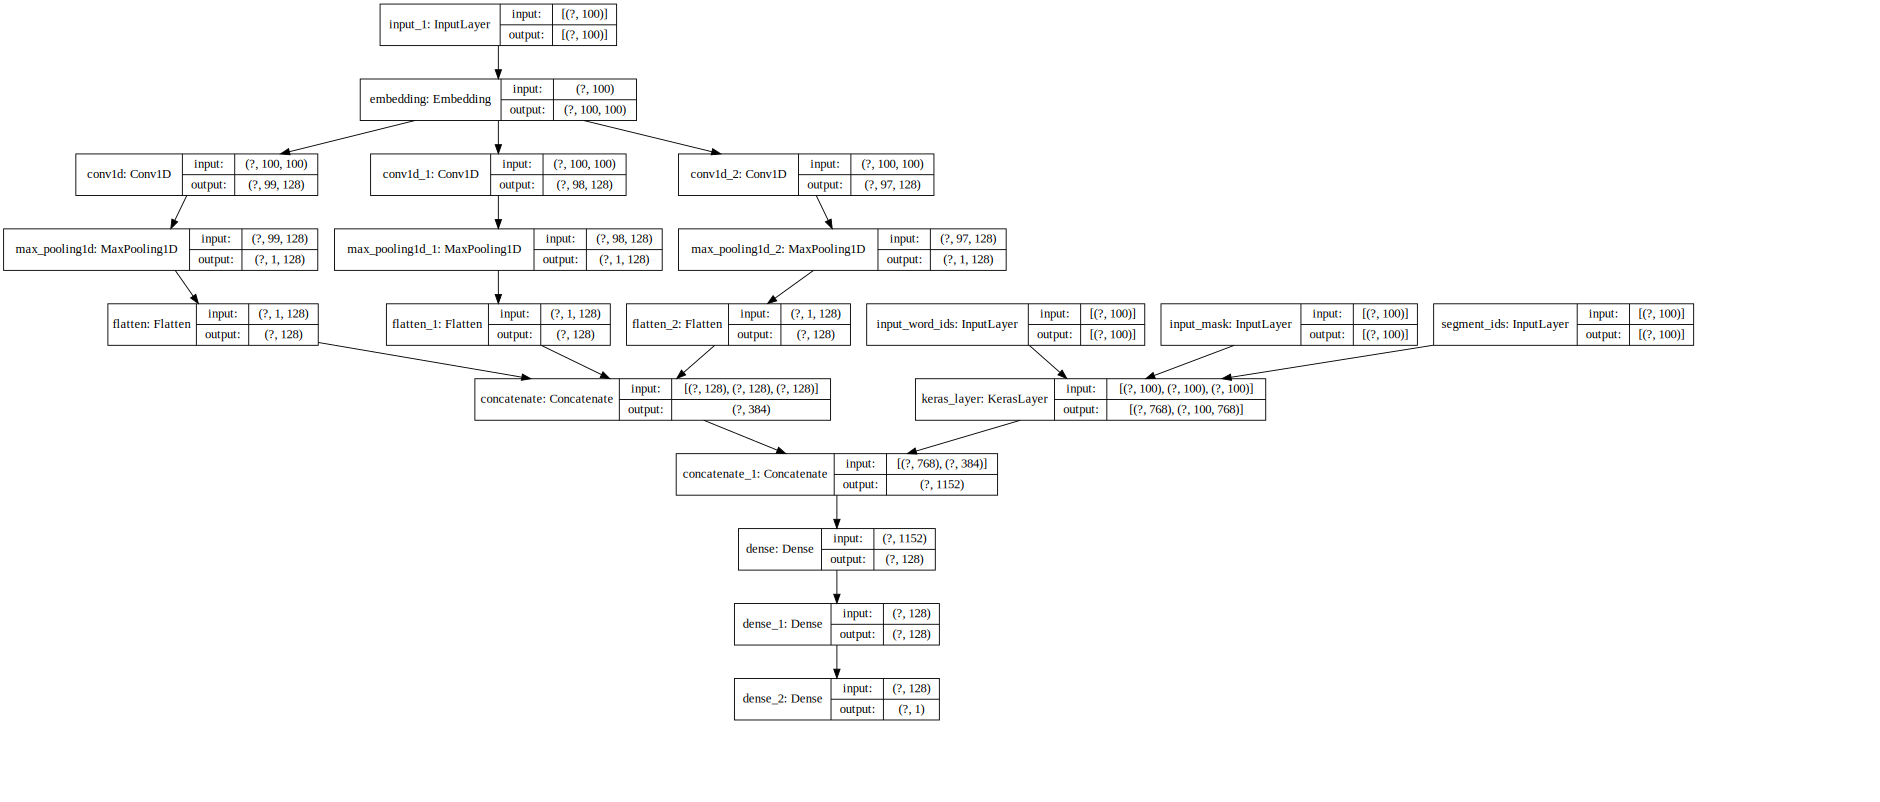

In [27]:
from IPython.display import SVG
SVG(tf.keras.utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [28]:
history = model.fit([X_train,train_input],y_train0,validation_split=0.2,epochs=2,batch_size=64)    

Epoch 1/2
10079/10079 [==============================] - 7644s 758ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 3.1959e-06 - val_accuracy: 1.0000
Epoch 2/2
10079/10079 [==============================] - 7647s 759ms/step - loss: 1.0952e-06 - accuracy: 1.0000 - val_loss: 2.9495e-08 - val_accuracy: 1.0000


In [29]:
score = model.evaluate([X_test,test_input],y_test0, verbose=1)           

6299/6299 [==============================] - 787s 125ms/step - loss: 2.9569e-08 - accuracy: 1.0000


In [31]:
model.save(r'/gdrive/My Drive/AELOG.h5')      
model.save(r'/gdrive/My Drive/Aelog')

INFO:tensorflow:Assets written to: /gdrive/My Drive/Aelog/assets


INFO:tensorflow:Assets written to: /gdrive/My Drive/Aelog/assets
